# Modified BattleShip

The modified battleship game occurs on a 10x10 grid map. A human player is given 1x length 2 ship, 2x length 3 ship, 1x length 4 ship, and 1x length 5 ship to place on the given grid map. 
The blue tiles mark the positions where the ships are placed, while the white tiles mark the positions where no ships are placed. The tiles which are struck (picked/guessed) are marked with a cross. 
The locations of the ships (blue tiles) are unknown to the agent. All tiles on the map appear white to the agent, with struck areas marked with a cross. However, if the agent strikes a ship tile, the tile will turn blue with a marked cross. 


The objective of the agent is to destroy all five ships by striking (guessing/picking) all blue tiles in the grid map, while minimising the number of strikes. The game starts from the start position with an unmarked map grip with the human assigned ships, and ends at the goal position with all blue tiles marked with a cross. 

The total number of game states is equal to the total number of combinations of strikes executed by the agent until all blue tiles are marked with a cross. The game state changes whenever the agent strikes a tile. 


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import networkx as nx
import queue

## Battleship Grid Visualised

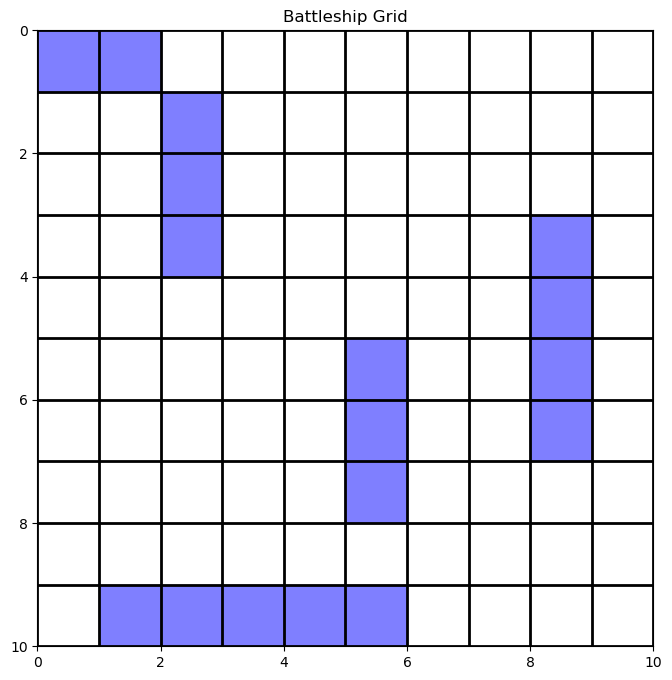

In [13]:
# Creating the 10x10 grid, and placing the ships on the grid
class BattleshipGame:
    def __init__(self):
        self.board_size = 10
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        self.ship_positions = []

    def place_ships(self, ship_positions):
        self.ship_positions = ship_positions
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        for (start, end) in self.ship_positions:
            if start[0] == end[0]:  # Horizontal ship
                self.board[start[0], start[1]:end[1] + 1] = 1
            else:  # Vertical ship
                self.board[start[0]:end[0] + 1, start[1]] = 1

    def plot_board(self, show_ships=False):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title('Battleship Grid')

        # Draw the grid
        for i in range(self.board_size + 1):
            ax.axhline(i, color='black', lw=2)
            ax.axvline(i, color='black', lw=2)

        # Mark ship positions
        if show_ships:
            for (start, end) in self.ship_positions:
                if start[0] == end[0]:  # Horizontal ship
                    for y in range(start[1], end[1] + 1):
                        ax.fill_betweenx([start[0], start[0] + 1], y, y + 1, color='blue', alpha=0.5)
                else:  # Vertical ship
                    for x in range(start[0], end[0] + 1):
                        ax.fill_between([start[1], start[1] + 1], x, x + 1, color='blue', alpha=0.5)

        # Mark guessed positions
        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.board[i, j] == 2:
                    ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='red'))

        ax.set_xlim(0, self.board_size)
        ax.set_ylim(0, self.board_size)
        ax.invert_yaxis()
        ax.set_aspect('equal', 'box')
        plt.show()

    # Attacking the grid slots using AI
    def attack(self, x, y):
        if self.board[x, y] == 1:
            self.board[x, y] = 2  # Mark as hit
            return 'hit'
        else:
            self.board[x, y] = 3  # Mark as miss
            return 'miss'

# Create and play the Battleship game with fixed ship positions
ship_positions = [((0, 0), (0, 1)), ((1, 2), (3, 2)), ((5, 5), (7, 5)), ((3, 8), (6, 8)), ((9, 1), (9, 5))]
game = BattleshipGame()
game.place_ships(ship_positions)
game.plot_board(show_ships=True)

## Our Battleship Grid (2-D Array Version)

In [14]:
# Define the board size
board_size = 10

# Create a 2D array (board) initialized with zeros
board = np.zeros((board_size, board_size), dtype=int)

# Manually place ships on the board (for demonstration purposes)
# Place a ship of length 2 horizontally at (0, 0) to (0, 1)
board[0, 0] = 1
board[0, 1] = 1

# Place a ship of length 3 vertically at (2, 3) to (4, 3)
board[2, 3] = 1
board[3, 3] = 1
board[4, 3] = 1

# Place another ship of length 3 vertically at (5, 5) to (7, 5)
board[5, 5] = 1
board[6, 5] = 1
board[7, 5] = 1

# Place a ship of length 4 vertically at (3, 8) to (6, 8)
board[3, 8] = 1
board[4, 8] = 1
board[5, 8] = 1
board[6, 8] = 1

# Place a ship of length 5 horizontally at (9, 1) to (9, 5)
board[9, 1] = 1
board[9, 2] = 1
board[9, 3] = 1
board[9, 4] = 1
board[9, 5] = 1

# Display the Battleship grid array
print(board)


[[1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 0 0 0 0]]


## BFS Method

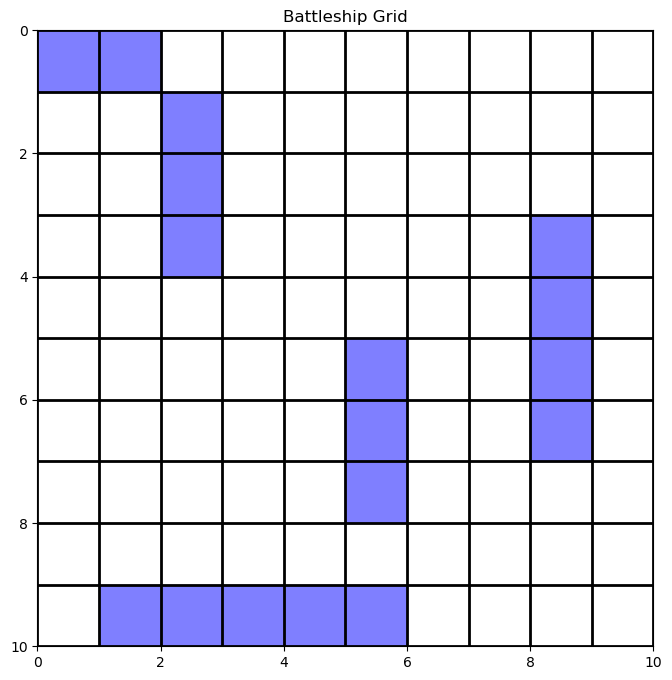

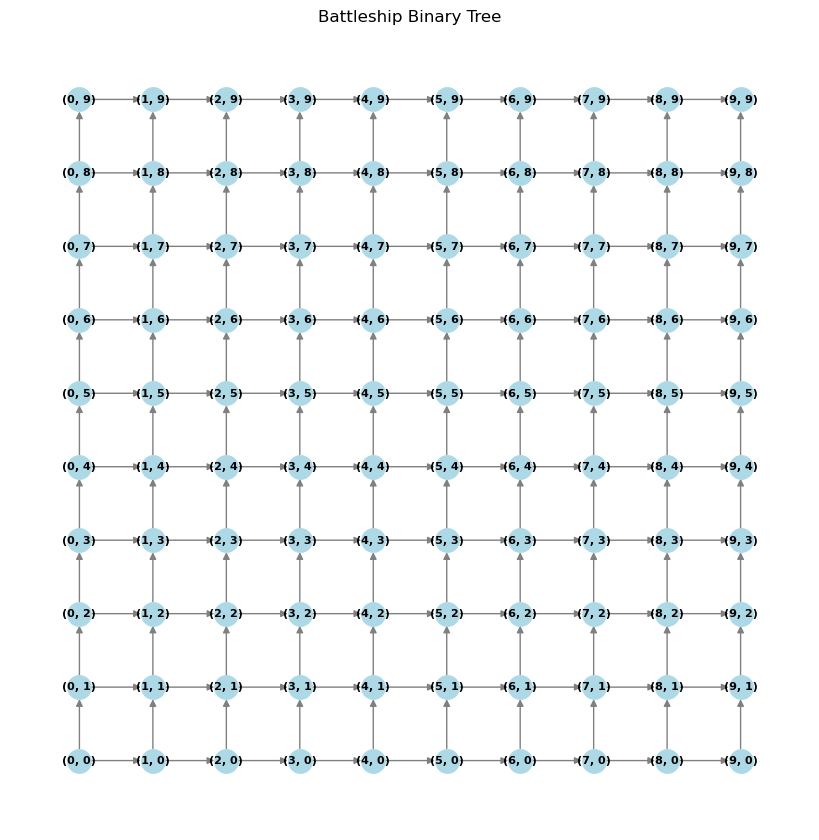

Final Board State (0 for water, 1 for ship segments, 2 for hit ship segments, 3 for missed shots):
2 2 3 3 3 3 3 3 3 3
3 3 2 3 3 3 3 3 3 3
3 3 2 3 3 3 3 3 3 3
3 3 2 3 3 3 3 3 2 3
3 3 3 3 3 3 3 3 2 3
3 3 3 3 3 2 3 3 2 3
3 3 3 3 3 2 3 3 2 0
3 3 3 3 3 2 3 3 0 0
3 3 3 3 3 3 3 0 0 0
3 2 2 2 2 2 0 0 0 0
Number of non-zero values (ship segments, hit ship segments, missed shots): 90


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque

class BattleshipBinaryTree:
    def __init__(self):
        self.board_size = 10
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        self.ship_positions = []

    def place_ships(self, ship_positions):
        self.ship_positions = ship_positions
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        for (start, end) in self.ship_positions:
            if start[0] == end[0]:  # Horizontal ship
                self.board[start[0], start[1]:end[1] + 1] = 1
            else:  # Vertical ship
                self.board[start[0]:end[0] + 1, start[1]] = 1

    def plot_board(self, show_ships=False):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title('Battleship Grid')

        # Draw the grid
        for i in range(self.board_size + 1):
            ax.axhline(i, color='black', lw=2)
            ax.axvline(i, color='black', lw=2)

        # Mark ship positions
        if show_ships:
            for (start, end) in self.ship_positions:
                if start[0] == end[0]:  # Horizontal ship
                    for y in range(start[1], end[1] + 1):
                        ax.fill_betweenx([start[0], start[0] + 1], y, y + 1, color='blue', alpha=0.5)
                else:  # Vertical ship
                    for x in range(start[0], end[0] + 1):
                        ax.fill_between([start[1], start[1] + 1], x, x + 1, color='blue', alpha=0.5)

        # Mark guessed positions
        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.board[i, j] == 2:
                    ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='red'))

        ax.set_xlim(0, self.board_size)
        ax.set_ylim(0, self.board_size)
        ax.invert_yaxis()
        ax.set_aspect('equal', 'box')
        plt.show()

    # Converting the grid to a Binary Tree Data Structure
    def convert_to_binary_tree(self):
        G = nx.DiGraph()

        # Add nodes for each cell in the grid
        for i in range(self.board_size):
            for j in range(self.board_size):
                G.add_node((i, j))

        # Add edges to create binary tree structure
        for i in range(self.board_size):
            for j in range(self.board_size):
                if j < self.board_size - 1:  # Add edge to cell on the right
                    G.add_edge((i, j), (i, j + 1))
                if i < self.board_size - 1:  # Add edge to cell below
                    G.add_edge((i, j), (i + 1, j))

        return G

    # BFS Search Algorithm
    def bfs_search(self, start_node=(0, 0)):
        queue = deque([(start_node, 0)])  # (current node, number of moves)
        visited = set()
        hits = set()
        while queue:
            current_node, moves = queue.popleft()
            if current_node in visited:
                continue
            visited.add(current_node)
            x, y = current_node
            if self.board[x, y] == 1:  # Check if ship segment is hit
                self.board[x, y] = 2  # Mark as hit
                hits.add((x, y))
                if len(hits) == self.total_ship_segments():
                    return moves + 1  # All ships hit, return number of moves
            else:
                self.board[x, y] = 3  # Mark as missed shot
            # Add neighbors (right and below) to the queue
            if y < self.board_size - 1:
                queue.append(((x, y + 1), moves + 1))  # Move right
            if x < self.board_size - 1:
                queue.append(((x + 1, y), moves + 1))  # Move down
        return -1  # If all ships are not hit within max moves, return -1

    def total_ship_segments(self):
        return sum([(end[1] - start[1] + 1) if start[0] == end[0] else (end[0] - start[0] + 1)
                    for (start, end) in self.ship_positions])

# Define ship positions
ship_positions = [((0, 0), (0, 1)), ((1, 2), (3, 2)), ((5, 5), (7, 5)), ((3, 8), (6, 8)), ((9, 1), (9, 5))]

# Create and play the Battleship game
game = BattleshipBinaryTree()
game.place_ships(ship_positions)
game.plot_board(show_ships=True)

# Convert grid to binary tree
binary_tree = game.convert_to_binary_tree()

# Visualize the binary tree
plt.figure(figsize=(8, 8))
pos = {node: node for node in binary_tree.nodes()}
nx.draw(binary_tree, pos=pos, with_labels=True, node_size=300, node_color='lightblue', font_size=8, font_color='black', font_weight='bold', edge_color='gray', linewidths=0.5)
plt.title('Battleship Binary Tree')
plt.show()

# Perform BFS search from the top-left corner (0, 0) first grid slot
total_moves = game.bfs_search()
#print("Total moves to sink all ships:", total_moves)

# Display the final state of the board
print("Final Board State (0 for water, 1 for ship segments, 2 for hit ship segments, 3 for missed shots):")
for row in game.board:
    print(' '.join(str(cell) for cell in row))

# Count the number of non-zero values in the final board state
non_zero_count = np.count_nonzero(game.board)
print("Number of non-zero values (ship segments, hit ship segments, missed shots):", non_zero_count)


## Uniform-Cost Search Method

In [16]:
from queue import PriorityQueue

print("Initial State of Board (in 2D)")
class BattleshipUCS:
    def __init__(self):
        self.board_size = 10
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        self.ship_positions = []
    
    def place_ships(self, ship_positions):
        self.ship_positions = ship_positions
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        for (start, end) in self.ship_positions:
            if start[0] == end[0]:  # Horizontal ship
                self.board[start[0], start[1]:end[1] + 1] = 1
            else:  # Vertical ship
                self.board[start[0]:end[0] + 1, start[1]] = 1

    def print_board(self):
        for row in self.board:
            print(' '.join(str(cell) for cell in row))
    
    # Uniform Cost Search Method
    def uniform_cost_search(self, start_node=(0, 0)):
        queue = PriorityQueue()
        queue.put((0, start_node))  # (cumulative cost, current node)
        visited = set()
        hits = set()
        total_moves = 0

        while not queue.empty():
            cost, current_node = queue.get()
            if current_node in visited:
                continue
            visited.add(current_node)

            x, y = current_node
            if self.board[x, y] == 1:  # Check if ship segment is hit
                self.board[x, y] = 2  # Mark as hit
                hits.add((x, y))
                total_moves += 1
                if len(hits) == self.total_ship_segments():
                    print("Final state of the board (in 2D)")
                    self.print_board()
                    return cost  # All ships hit, return cumulative cost
            else:
                self.board[x, y] = 3  # Mark as missed shot
                total_moves += 1

            # Add neighbors (up, down, left, right) to the queue with updated costs
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.board_size and 0 <= ny < self.board_size:
                    queue.put((cost + 1, (nx, ny)))  # Increment the cost for each move
        print("Final state of the board (in 2D)")
        self.print_board()
        return -1  # If all ships are not hit within max moves, return -1

    def total_ship_segments(self):
        return sum([(end[1] - start[1] + 1) if start[0] == end[0] else (end[0] - start[0] + 1)
                    for (start, end) in self.ship_positions])

# Define ship positions
ship_positions = [((0, 0), (0, 1)), ((1, 2), (3, 2)), ((5, 5), (7, 5)), ((3, 8), (6, 8)), ((9, 1), (9, 5))]

# Create and play the Battleship game using UCS
game = BattleshipUCS()
game.place_ships(ship_positions)
game.print_board()

# Perform Uniform Cost Search from the top-left corner (0, 0)
total_moves = game.uniform_cost_search()
# Count the number of non-zero values in the final board state
non_zero_count = np.count_nonzero(game.board)
print("Number of non-zero values (ship segments, hit ship segments, missed shots):", non_zero_count)

Initial State of Board (in 2D)
1 1 0 0 0 0 0 0 0 0
0 0 1 0 0 0 0 0 0 0
0 0 1 0 0 0 0 0 0 0
0 0 1 0 0 0 0 0 1 0
0 0 0 0 0 0 0 0 1 0
0 0 0 0 0 1 0 0 1 0
0 0 0 0 0 1 0 0 1 0
0 0 0 0 0 1 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 1 1 1 1 1 0 0 0 0
Final state of the board (in 2D)
2 2 3 3 3 3 3 3 3 3
3 3 2 3 3 3 3 3 3 3
3 3 2 3 3 3 3 3 3 3
3 3 2 3 3 3 3 3 2 3
3 3 3 3 3 3 3 3 2 3
3 3 3 3 3 2 3 3 2 3
3 3 3 3 3 2 3 3 2 0
3 3 3 3 3 2 3 3 0 0
3 3 3 3 3 3 3 0 0 0
3 2 2 2 2 2 0 0 0 0
Number of non-zero values (ship segments, hit ship segments, missed shots): 90


## DFS Method

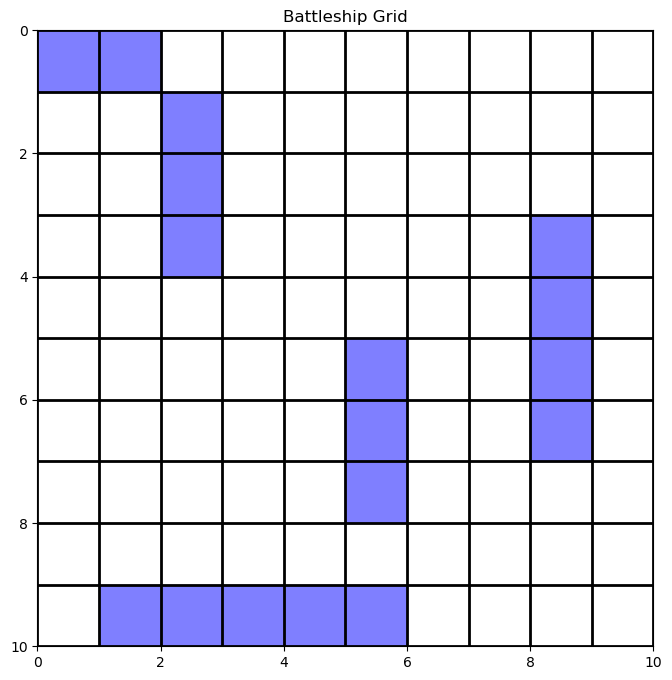

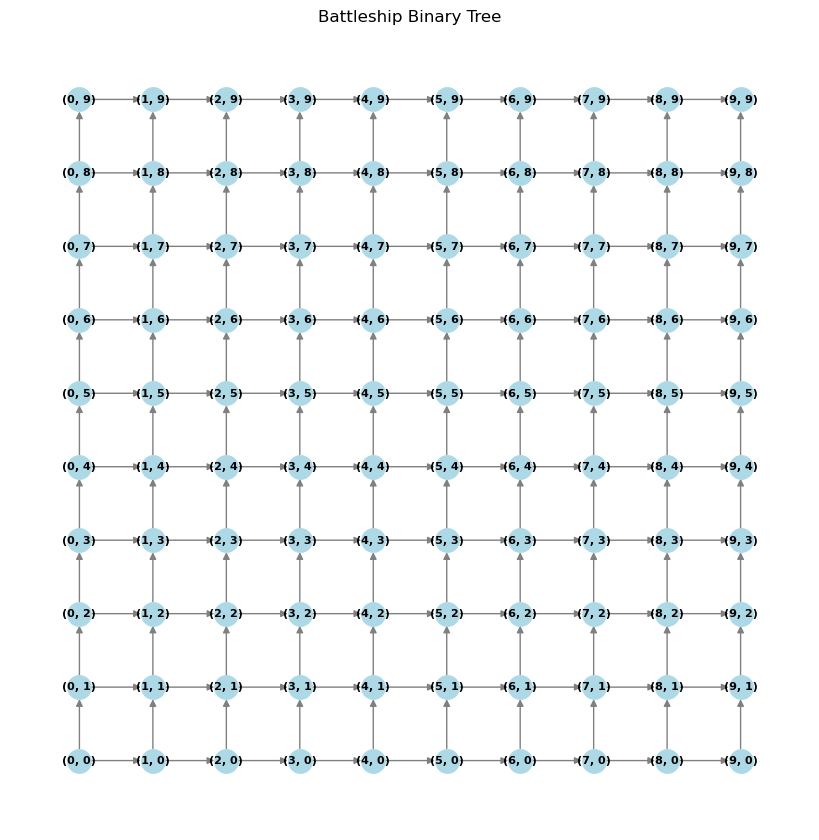

Final Board State (0 for water, 1 for ship segments, 2 for hit ship segments, 3 for missed shots):
2 2 3 3 3 3 3 3 3 3
0 3 2 3 3 3 3 3 3 3
0 3 2 3 3 3 3 3 3 3
0 3 2 3 3 3 3 3 2 3
0 3 3 3 3 3 3 3 2 3
0 3 3 3 3 2 3 3 2 3
0 3 3 3 3 2 3 3 2 3
0 3 3 3 3 2 3 3 3 3
0 3 3 3 3 3 3 3 3 3
0 2 2 2 2 2 3 3 3 3
Number of non-zero values (ship segments, hit ship segments, missed shots): 91


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque

class BattleshipBinaryTree:
    def __init__(self):
        self.board_size = 10
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        self.ship_positions = []

    def place_ships(self, ship_positions):
        self.ship_positions = ship_positions
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        for (start, end) in self.ship_positions:
            if start[0] == end[0]:  # Horizontal ship
                self.board[start[0], start[1]:end[1] + 1] = 1
            else:  # Vertical ship
                self.board[start[0]:end[0] + 1, start[1]] = 1

    def plot_board(self, show_ships=False):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title('Battleship Grid')

        # Draw the grid
        for i in range(self.board_size + 1):
            ax.axhline(i, color='black', lw=2)
            ax.axvline(i, color='black', lw=2)

        # Mark ship positions
        if show_ships:
            for (start, end) in self.ship_positions:
                if start[0] == end[0]:  # Horizontal ship
                    for y in range(start[1], end[1] + 1):
                        ax.fill_betweenx([start[0], start[0] + 1], y, y + 1, color='blue', alpha=0.5)
                else:  # Vertical ship
                    for x in range(start[0], end[0] + 1):
                        ax.fill_between([start[1], start[1] + 1], x, x + 1, color='blue', alpha=0.5)

        # Mark guessed positions
        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.board[i, j] == 2:
                    ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='red'))

        ax.set_xlim(0, self.board_size)
        ax.set_ylim(0, self.board_size)
        ax.invert_yaxis()
        ax.set_aspect('equal', 'box')
        plt.show()

    def convert_to_binary_tree(self):
        G = nx.DiGraph()

        # Add nodes for each cell in the grid
        for i in range(self.board_size):
            for j in range(self.board_size):
                G.add_node((i, j))

        # Add edges to create binary tree structure
        for i in range(self.board_size):
            for j in range(self.board_size):
                if j < self.board_size - 1:  # Add edge to cell on the right
                    G.add_edge((i, j), (i, j + 1))
                if i < self.board_size - 1:  # Add edge to cell below
                    G.add_edge((i, j), (i + 1, j))

        return G

    # DFS Search Method
    def dfs_search(self, start_node=(0, 0)):
        stack = [(start_node, 0)]  # (current node, number of moves)
        visited = set()
        hits = set()
        while stack:
            current_node, moves = stack.pop()
            if current_node in visited:
                continue
            visited.add(current_node)
            x, y = current_node
            if self.board[x, y] == 1:  # Check if ship segment is hit
                self.board[x, y] = 2  # Mark as hit
                hits.add((x, y))
                if len(hits) == self.total_ship_segments():
                    return moves + 1  # All ships hit, return number of moves
            else:
                self.board[x, y] = 3  # Mark as missed shot
            # Add neighbors (right and below) to the stack (in reverse order)
            if x < self.board_size - 1:
                stack.append(((x + 1, y), moves + 1))  # Move down
            if y < self.board_size - 1:
                stack.append(((x, y + 1), moves + 1))  # Move right
        return -1  # If all ships are not hit within max moves, return -1

    def total_ship_segments(self):
        return sum([(end[1] - start[1] + 1) if start[0] == end[0] else (end[0] - start[0] + 1)
                    for (start, end) in self.ship_positions])

# Define ship positions
ship_positions = [((0, 0), (0, 1)), ((1, 2), (3, 2)), ((5, 5), (7, 5)), ((3, 8), (6, 8)), ((9, 1), (9, 5))]

# Create and play the Battleship game
game = BattleshipBinaryTree()
game.place_ships(ship_positions)
game.plot_board(show_ships=True)

# Convert grid to binary tree
binary_tree = game.convert_to_binary_tree()

# Visualize the binary tree
plt.figure(figsize=(8, 8))
pos = {node: node for node in binary_tree.nodes()}
nx.draw(binary_tree, pos=pos, with_labels=True, node_size=300, node_color='lightblue', font_size=8, font_color='black', font_weight='bold', edge_color='gray', linewidths=0.5)
plt.title('Battleship Binary Tree')
plt.show()

# Perform DFS search from the top-left corner (0, 0)
total_moves = game.dfs_search()
#print("Total moves to sink all ships:", total_moves)

# Display the final state of the board
print("Final Board State (0 for water, 1 for ship segments, 2 for hit ship segments, 3 for missed shots):")
for row in game.board:
    print(' '.join(str(cell) for cell in row))

# Count the number of non-zero values in the final board state
non_zero_count = np.count_nonzero(game.board)
print("Number of non-zero values (ship segments, hit ship segments, missed shots):", non_zero_count)


## Greedy Search Method

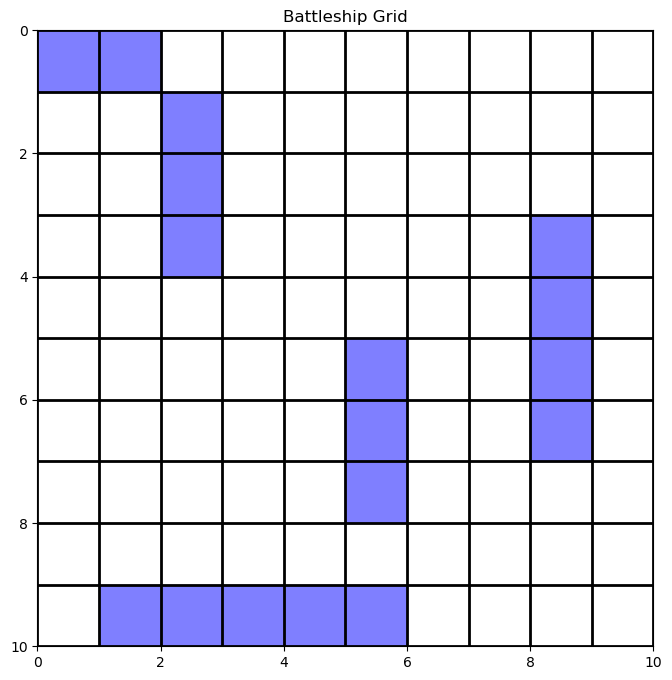

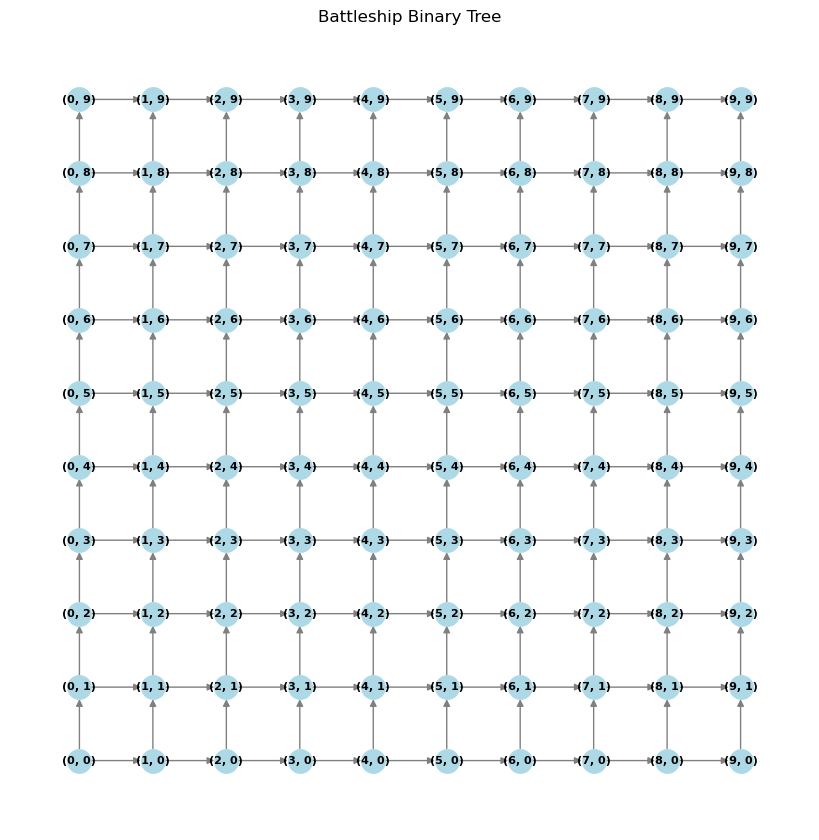

Total moves to sink all ships: 15
Final Board State (0 for water, 1 for ship segments, 2 for hit ship segments, 3 for missed shots):
2 2 3 3 3 3 3 3 3 3
3 3 2 3 3 3 3 3 3 3
3 3 2 3 3 3 3 3 3 3
3 3 2 3 3 3 3 3 2 3
3 3 3 3 3 3 3 3 2 3
3 3 3 3 3 2 3 3 2 3
3 3 3 3 3 2 3 3 2 0
3 3 3 3 3 2 3 3 0 0
3 3 3 3 3 3 3 0 0 0
3 2 2 2 2 2 0 0 0 0
Number of non-zero values (ship segments, hit ship segments, missed shots): 90


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque

class BattleshipBinaryTree:
    def __init__(self):
        self.board_size = 10
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        self.ship_positions = []

    def place_ships(self, ship_positions):
        self.ship_positions = ship_positions
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        for (start, end) in self.ship_positions:
            if start[0] == end[0]:  # Horizontal ship
                self.board[start[0], start[1]:end[1] + 1] = 1
            else:  # Vertical ship
                self.board[start[0]:end[0] + 1, start[1]] = 1

    def plot_board(self, show_ships=False):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title('Battleship Grid')

        # Draw the grid
        for i in range(self.board_size + 1):
            ax.axhline(i, color='black', lw=2)
            ax.axvline(i, color='black', lw=2)

        # Mark ship positions
        if show_ships:
            for (start, end) in self.ship_positions:
                if start[0] == end[0]:  # Horizontal ship
                    for y in range(start[1], end[1] + 1):
                        ax.fill_betweenx([start[0], start[0] + 1], y, y + 1, color='blue', alpha=0.5)
                else:  # Vertical ship
                    for x in range(start[0], end[0] + 1):
                        ax.fill_between([start[1], start[1] + 1], x, x + 1, color='blue', alpha=0.5)

        # Mark guessed positions
        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.board[i, j] == 2:
                    ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='red'))

        ax.set_xlim(0, self.board_size)
        ax.set_ylim(0, self.board_size)
        ax.invert_yaxis()
        ax.set_aspect('equal', 'box')
        plt.show()

    def convert_to_binary_tree(self):
        G = nx.DiGraph()

        # Add nodes for each cell in the grid
        for i in range(self.board_size):
            for j in range(self.board_size):
                G.add_node((i, j))

        # Add edges to create binary tree structure
        for i in range(self.board_size):
            for j in range(self.board_size):
                if j < self.board_size - 1:  # Add edge to cell on the right
                    G.add_edge((i, j), (i, j + 1))
                if i < self.board_size - 1:  # Add edge to cell below
                    G.add_edge((i, j), (i + 1, j))

        return G

    # Greedy Search Method
    def greedy_search(self, start_node=(0, 0)):
        queue = deque([(start_node, 0)])  # (current node, number of moves)
        visited = set()
        hits = set()
        while queue:
            current_node, moves = queue.popleft()
            if current_node in visited:
                continue
            visited.add(current_node)
            x, y = current_node
            if self.board[x, y] == 1:  # Check if ship segment is hit
                self.board[x, y] = 2  # Mark as hit
                hits.add((x, y))
                if len(hits) == self.total_ship_segments():
                    return moves + 1  # All ships hit, return number of moves
            else:
                self.board[x, y] = 3  # Mark as missed shot
            # Add neighbors (right and below) to the queue (in order of priority)
            if y < self.board_size - 1:
                queue.append(((x, y + 1), moves + 1))  # Move right
            if x < self.board_size - 1:
                queue.append(((x + 1, y), moves + 1))  # Move down
        return -1  # If all ships are not hit within max moves, return -1

    def total_ship_segments(self):
        return sum([(end[1] - start[1] + 1) if start[0] == end[0] else (end[0] - start[0] + 1)
                    for (start, end) in self.ship_positions])

# Define ship positions
ship_positions = [((0, 0), (0, 1)), ((1, 2), (3, 2)), ((5, 5), (7, 5)), ((3, 8), (6, 8)), ((9, 1), (9, 5))]

# Create and play the Battleship game
game = BattleshipBinaryTree()
game.place_ships(ship_positions)
game.plot_board(show_ships=True)

# Convert grid to binary tree
binary_tree = game.convert_to_binary_tree()

# Visualize the binary tree
plt.figure(figsize=(8, 8))
pos = {node: node for node in binary_tree.nodes()}
nx.draw(binary_tree, pos=pos, with_labels=True, node_size=300, node_color='lightblue', font_size=8, font_color='black', font_weight='bold', edge_color='gray', linewidths=0.5)
plt.title('Battleship Binary Tree')
plt.show()

# Perform greedy search from the top-left corner (0, 0)
total_moves = game.greedy_search()
print("Total moves to sink all ships:", total_moves)

# Display the final state of the board
print("Final Board State (0 for water, 1 for ship segments, 2 for hit ship segments, 3 for missed shots):")
for row in game.board:
    print(' '.join(str(cell) for cell in row))

# Count the number of non-zero values in the final board state
non_zero_count = np.count_nonzero(game.board)
print("Number of non-zero values (ship segments, hit ship segments, missed shots):", non_zero_count)


## Beam Search Method

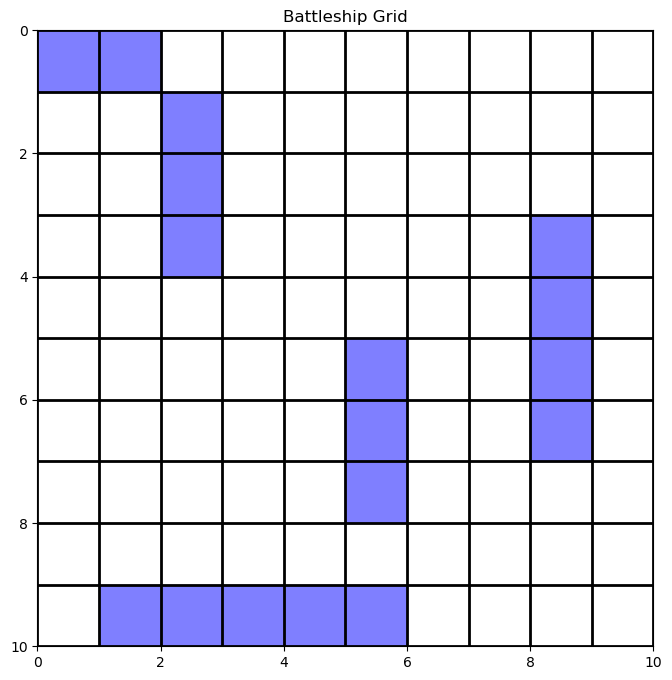

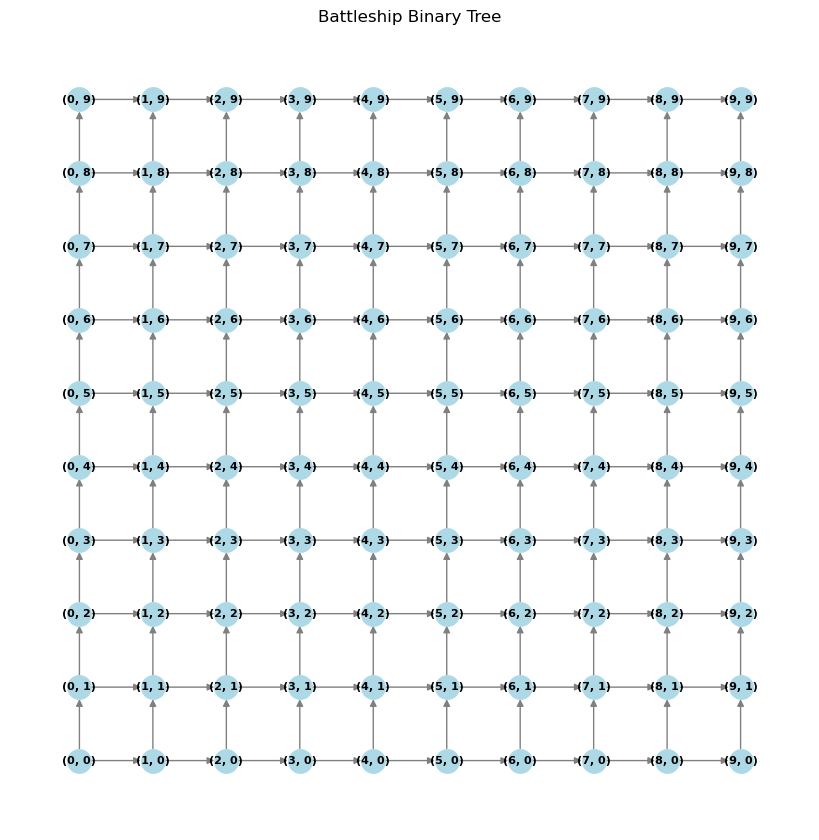

Ship Slots Sunk: 5/17 slots
Final Board State (0 for water, 1 for ship segments, 2 for hit ship segments, 3 for missed shots):
2 2 3 3 3 3 3 3 3 3
3 3 2 3 3 3 3 3 3 3
0 0 1 0 0 0 0 0 0 3
0 0 1 0 0 0 0 0 1 3
0 0 0 0 0 0 0 0 1 3
0 0 0 0 0 1 0 0 1 3
0 0 0 0 0 1 0 0 1 3
0 0 0 0 0 1 0 0 0 3
0 0 0 0 0 0 0 0 0 3
0 1 1 1 1 1 0 0 0 3
Number of non-zero values (ship segments, hit ship segments, missed shots): 42


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque

class BattleshipBinaryTree:
    def __init__(self):
        self.board_size = 10
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        self.ship_positions = []

    def place_ships(self, ship_positions):
        self.ship_positions = ship_positions
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        for (start, end) in self.ship_positions:
            if start[0] == end[0]:  # Horizontal ship
                self.board[start[0], start[1]:end[1] + 1] = 1
            else:  # Vertical ship
                self.board[start[0]:end[0] + 1, start[1]] = 1

    def plot_board(self, show_ships=False):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title('Battleship Grid')

        # Draw the grid
        for i in range(self.board_size + 1):
            ax.axhline(i, color='black', lw=2)
            ax.axvline(i, color='black', lw=2)

        # Mark ship positions
        if show_ships:
            for (start, end) in self.ship_positions:
                if start[0] == end[0]:  # Horizontal ship
                    for y in range(start[1], end[1] + 1):
                        ax.fill_betweenx([start[0], start[0] + 1], y, y + 1, color='blue', alpha=0.5)
                else:  # Vertical ship
                    for x in range(start[0], end[0] + 1):
                        ax.fill_between([start[1], start[1] + 1], x, x + 1, color='blue', alpha=0.5)

        # Mark guessed positions
        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.board[i, j] == 2:
                    ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='red'))

        ax.set_xlim(0, self.board_size)
        ax.set_ylim(0, self.board_size)
        ax.invert_yaxis()
        ax.set_aspect('equal', 'box')
        plt.show()

    def convert_to_binary_tree(self):
        G = nx.DiGraph()

        # Add nodes for each cell in the grid
        for i in range(self.board_size):
            for j in range(self.board_size):
                G.add_node((i, j))

        # Add edges to create binary tree structure
        for i in range(self.board_size):
            for j in range(self.board_size):
                if j < self.board_size - 1:  # Add edge to cell on the right
                    G.add_edge((i, j), (i, j + 1))
                if i < self.board_size - 1:  # Add edge to cell below
                    G.add_edge((i, j), (i + 1, j))

        return G

    # Beam Search Method
    def beam_search(self, start_node=(0, 0), beam_width=2):
        queue = deque([(start_node, 0)])  # (current node, number of moves)
        visited = set()
        hits = set()
        while queue:
            # Sort the queue by the number of moves (ascending order) and keep the top beam_width nodes
            queue = deque(sorted(queue, key=lambda x: x[1])[:beam_width])
            current_node, moves = queue.popleft()
            if current_node in visited:
                continue
            visited.add(current_node)
            x, y = current_node
            if self.board[x, y] == 1:  # Check if ship segment is hit
                self.board[x, y] = 2  # Mark as hit
                hits.add((x, y))
                if len(hits) == self.total_ship_segments():
                    return moves + 1  # All ships hit, return number of moves
            else:
                self.board[x, y] = 3  # Mark as missed shot
            # Add neighbors (right and below) to the queue (in order of priority)
            if y < self.board_size - 1:
                queue.append(((x, y + 1), moves + 1))  # Move right
            if x < self.board_size - 1:
                queue.append(((x + 1, y), moves + 1))  # Move down
        return -1  # If all ships are not hit within max moves, return -1

    def total_ship_segments(self):
        return sum([(end[1] - start[1] + 1) if start[0] == end[0] else (end[0] - start[0] + 1)
                    for (start, end) in self.ship_positions])

# Define ship positions
ship_positions = [((0, 0), (0, 1)), ((1, 2), (3, 2)), ((5, 5), (7, 5)), ((3, 8), (6, 8)), ((9, 1), (9, 5))]

# Create and play the Battleship game
game = BattleshipBinaryTree()
game.place_ships(ship_positions)
game.plot_board(show_ships=True)

# Convert grid to binary tree
binary_tree = game.convert_to_binary_tree()

# Visualize the binary tree
plt.figure(figsize=(8, 8))
pos = {node: node for node in binary_tree.nodes()}
nx.draw(binary_tree, pos=pos, with_labels=True, node_size=300, node_color='lightblue', font_size=8, font_color='black', font_weight='bold', edge_color='gray', linewidths=0.5)
plt.title('Battleship Binary Tree')
plt.show()

# Perform Beam Search from the top-left corner (0, 0) with beam width of 2
total_moves = game.beam_search(beam_width=2)
print("Ship Slots Sunk: 5/17 slots")

# Display the final state of the board
print("Final Board State (0 for water, 1 for ship segments, 2 for hit ship segments, 3 for missed shots):")
for row in game.board:
    print(' '.join(str(cell) for cell in row))

# Count the number of non-zero values in the final board state
non_zero_count = np.count_nonzero(game.board)
print("Number of non-zero values (ship segments, hit ship segments, missed shots):", non_zero_count)


## A-Star Search Method

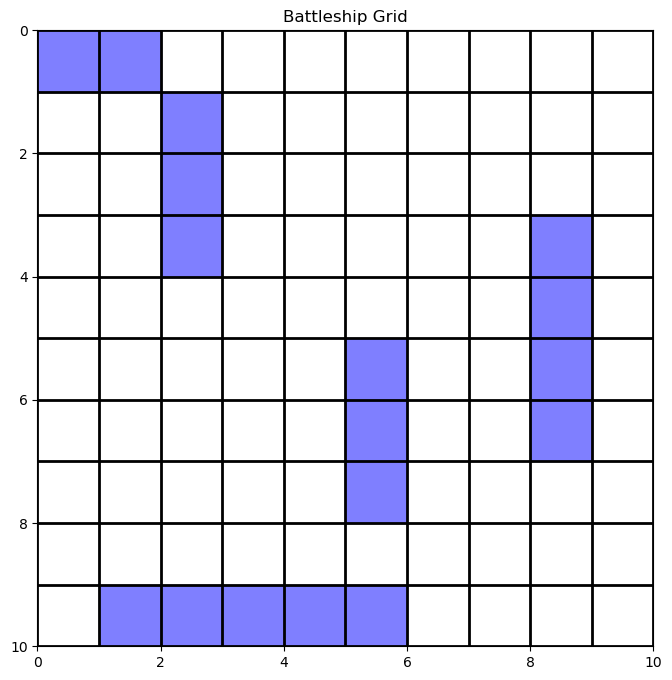

Final Board State (0 for water, 1 for ship segments, 2 for hit ship segments, 3 for missed shots):
2 2 0 0 0 0 0 0 0 0
0 0 2 0 0 0 0 0 0 0
0 0 2 0 0 0 0 0 0 0
0 0 2 0 0 0 0 0 2 0
0 0 0 0 0 0 0 0 2 0
0 0 0 0 0 2 0 0 2 0
0 0 0 0 0 2 0 0 2 0
0 0 0 0 0 2 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 2 2 2 2 2 0 0 0 0
Number of non-zero values (ship segments, hit ship segments, missed shots): 17


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque

class BattleshipAStar:
    def __init__(self):
        self.board_size = 10
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        self.ship_positions = []
    
    def place_ships(self, ship_positions):
        self.ship_positions = ship_positions
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        for (start, end) in self.ship_positions:
            if start[0] == end[0]:  # Horizontal ship
                self.board[start[0], start[1]:end[1] + 1] = 1
            else:  # Vertical ship
                self.board[start[0]:end[0] + 1, start[1]] = 1

    def plot_board(self, show_ships=False):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title('Battleship Grid')

        # Draw the grid
        for i in range(self.board_size + 1):
            ax.axhline(i, color='black', lw=2)
            ax.axvline(i, color='black', lw=2)

        # Mark ship positions
        if show_ships:
            for (start, end) in self.ship_positions:
                if start[0] == end[0]:  # Horizontal ship
                    for y in range(start[1], end[1] + 1):
                        ax.fill_betweenx([start[0], start[0] + 1], y, y + 1, color='blue', alpha=0.5)
                else:  # Vertical ship
                    for x in range(start[0], end[0] + 1):
                        ax.fill_between([start[1], start[1] + 1], x, x + 1, color='blue', alpha=0.5)

        # Mark guessed positions
        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.board[i, j] == 2:
                    ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='red'))

        ax.set_xlim(0, self.board_size)
        ax.set_ylim(0, self.board_size)
        ax.invert_yaxis()
        ax.set_aspect('equal', 'box')
        plt.show()

    def convert_to_binary_tree(self):
        G = nx.DiGraph()

        # Add nodes for each cell in the grid
        for i in range(self.board_size):
            for j in range(self.board_size):
                G.add_node((i, j))

        # Add edges to create binary tree structure
        for i in range(self.board_size):
            for j in range(self.board_size):
                if j < self.board_size - 1:  # Add edge to cell on the right
                    G.add_edge((i, j), (i, j + 1))
                if i < self.board_size - 1:  # Add edge to cell below
                    G.add_edge((i, j), (i + 1, j))

        return G

    # A* Star Search Method
    def astar_search(self, start_node=(0, 0)):
        open_list = [(start_node, 0, self.heuristic(start_node))]
        closed_list = set()
        hits = set()
        
        while open_list:
            current_node, moves, heuristic_cost = open_list.pop(0)
            
            if current_node in closed_list:
                continue
                
            closed_list.add(current_node)
            x, y = current_node
            
            if self.board[x, y] == 1:
                self.board[x, y] = 2
                hits.add((x, y))
                if len(hits) == self.total_ship_segments():
                    return moves + 1
                    
            for neighbor in self.get_neighbors(current_node):
                if neighbor in closed_list:
                    continue
                
                g = moves + 1
                h = self.heuristic(neighbor)
                f = g + h
                
                open_list.append((neighbor, g, h))
                open_list.sort(key=lambda x: x[2])
        
        return -1

    def heuristic(self, node):
        x, y = node
        min_distance = float('inf')
        for (start, end) in self.ship_positions:
            ship_x, ship_y = start
            distance = abs(x - ship_x) + abs(y - ship_y)
            min_distance = min(min_distance, distance)
        return min_distance

    def get_neighbors(self, node):
        x, y = node
        neighbors = []
        if x > 0:
            neighbors.append((x - 1, y))  # Move up
        if x < self.board_size - 1:
            neighbors.append((x + 1, y))  # Move down
        if y > 0:
            neighbors.append((x, y - 1))  # Move left
        if y < self.board_size - 1:
            neighbors.append((x, y + 1))  # Move right
        return neighbors

    def total_ship_segments(self):
        return sum([(end[1] - start[1] + 1) if start[0] == end[0] else (end[0] - start[0] + 1)
                    for (start, end) in self.ship_positions])

# Define ship positions
ship_positions = [((0, 0), (0, 1)), ((1, 2), (3, 2)), ((5, 5), (7, 5)), ((3, 8), (6, 8)), ((9, 1), (9, 5))]

# Create and play the Battleship game
game = BattleshipAStar()
game.place_ships(ship_positions)
game.plot_board(show_ships=True)

# Perform A* search from the top-left corner (0, 0)
total_moves = game.astar_search()
if total_moves != -1:
    #print("Total moves to sink all ships:", total_moves)
    print("Final Board State (0 for water, 1 for ship segments, 2 for hit ship segments, 3 for missed shots):")
    for row in game.board:
        print(' '.join(str(cell) for cell in row))
else:
    print("All ships could not be found within the maximum moves.")
    
# Count the number of non-zero values in the final board state
non_zero_count = np.count_nonzero(game.board)
print("Number of non-zero values (ship segments, hit ship segments, missed shots):", non_zero_count)

## Tabu Search

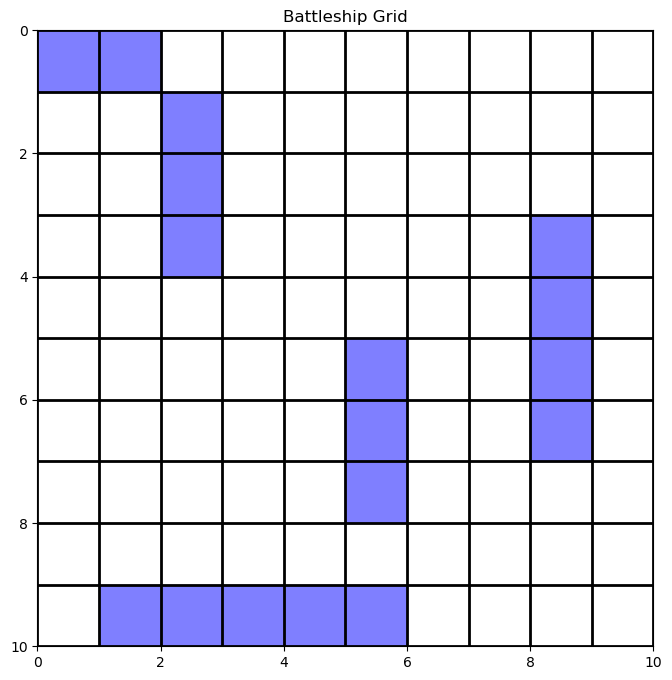

Final Board State (0 for water, 1 for ship segments, 2 for hit ship segments, 3 for missed shots):
2 2 0 0 0 0 0 0 0 0
0 0 2 0 0 0 0 0 0 0
0 0 2 0 0 0 0 0 0 0
0 0 2 0 0 0 0 0 2 0
0 0 0 0 0 0 0 0 2 0
0 0 0 0 0 2 0 0 2 0
0 0 0 0 0 2 0 0 2 0
0 0 0 0 0 2 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 2 2 2 2 2 0 0 0 0
Number of non-zero values (ship segments, hit ship segments, missed shots): 17


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

class BattleshipTabuSearch:
    def __init__(self):
        self.board_size = 10
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        self.ship_positions = []
        self.tabu_list = set()  # Initialize tabu list

    def place_ships(self, ship_positions):
        self.ship_positions = ship_positions
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        for (start, end) in self.ship_positions:
            if start[0] == end[0]:  # Horizontal ship
                self.board[start[0], start[1]:end[1] + 1] = 1
            else:  # Vertical ship
                self.board[start[0]:end[0] + 1, start[1]] = 1

    def plot_board(self, show_ships=False):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title('Battleship Grid')

        # Draw the grid
        for i in range(self.board_size + 1):
            ax.axhline(i, color='black', lw=2)
            ax.axvline(i, color='black', lw=2)

        # Mark ship positions
        if show_ships:
            for (start, end) in self.ship_positions:
                if start[0] == end[0]:  # Horizontal ship
                    for y in range(start[1], end[1] + 1):
                        ax.fill_betweenx([start[0], start[0] + 1], y, y + 1, color='blue', alpha=0.5)
                else:  # Vertical ship
                    for x in range(start[0], end[0] + 1):
                        ax.fill_between([start[1], start[1] + 1], x, x + 1, color='blue', alpha=0.5)

        # Mark guessed positions
        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.board[i, j] == 2:
                    ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='red'))

        ax.set_xlim(0, self.board_size)
        ax.set_ylim(0, self.board_size)
        ax.invert_yaxis()
        ax.set_aspect('equal', 'box')
        plt.show()

    # Tabu Search Method
    def tabu_search(self, start_node=(0, 0)):
        queue = deque([(start_node, 0)])  # (current node, number of moves)
        hits = set()
        
        while queue:
            current_node, moves = queue.popleft()
            if current_node in self.tabu_list:  # Check if current node is in tabu list
                continue
            
            self.tabu_list.add(current_node)  # Add current node to tabu list
            x, y = current_node
            if self.board[x, y] == 1:  # Check if ship segment is hit
                self.board[x, y] = 2  # Mark as hit
                hits.add((x, y))
                if len(hits) == self.total_ship_segments():
                    return moves + 1  # All ships hit, return number of moves
            
            # Add neighbors (right and below) to the queue
            if y < self.board_size - 1:
                queue.append(((x, y + 1), moves + 1))  # Move right
            if x < self.board_size - 1:
                queue.append(((x + 1, y), moves + 1))  # Move down
        
        return -1  # If all ships are not hit within max moves, return -1

    def total_ship_segments(self):
        return sum([(end[1] - start[1] + 1) if start[0] == end[0] else (end[0] - start[0] + 1)
                    for (start, end) in self.ship_positions])

# Define ship positions
ship_positions = [((0, 0), (0, 1)), ((1, 2), (3, 2)), ((5, 5), (7, 5)), ((3, 8), (6, 8)), ((9, 1), (9, 5))]

# Create and play the Battleship game using Tabu Search
game = BattleshipTabuSearch()
game.place_ships(ship_positions)
game.plot_board(show_ships=True)

# Perform Tabu Search from the top-left corner (0, 0)
total_moves = game.tabu_search()
if total_moves != -1:
    #print("Total moves to sink all ships:", total_moves)
    print("Final Board State (0 for water, 1 for ship segments, 2 for hit ship segments, 3 for missed shots):")
    for row in game.board:
        print(' '.join(str(cell) for cell in row))
else:
    print("All ships could not be found within the maximum moves.")
    
# Count the number of non-zero values in the final board state
non_zero_count = np.count_nonzero(game.board)
print("Number of non-zero values (ship segments, hit ship segments, missed shots):", non_zero_count)

## Conclusion

Our most efficient search algorithms are the Tabu Search Method & A* Star Search Method (100% ship hit rate) with 17 moves each.